# 0) Setup

In [3]:
# If needed:
# !pip -q install numpy pandas scikit-learn xgboost shap lime scipy matplotlib pyarrow

import os, json, time, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
from scipy.stats import wilcoxon

import shap
from lime.lime_tabular import LimeTabularExplainer

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
plt.rcParams["figure.dpi"] = 120

print("NumPy:", np.__version__)



NumPy: 1.26.4


# 1) Config — edit this path only

In [4]:
# === EDIT THIS LINE ONLY ===
TRAIN_TRANSACTION_PATH = "/Users/rightynighty/UCL/postgrad/Dissertation/Code/ieee-fraud-detection/train_transaction.csv"  # 👈 set your path

# Inferred paths & constants
BASE_DIR = Path(TRAIN_TRANSACTION_PATH).resolve().parent
TRAIN_IDENTITY_PATH = BASE_DIR / "train_identity.csv"

ART = Path("./artifacts"); ART.mkdir(exist_ok=True)
SEED = 0
rng = np.random.default_rng(SEED)

# Experiment knobs (lean defaults)
N_EXPLAIN = 30          # SHAP vs LIME comparison size
MIN_POS_EXPLAIN = 20     # try to include at least this many positives in N
MISS_THRESH = 0.20       # add __isna indicators where ≥20% missing
RARE_CAT_MIN = 100       # map rare categories (<100 rows) to _other


# 2) Utilities (prep + plotting + stats)

In [5]:
def clean_M_flags(df):
    mcols = [c for c in df.columns if c.startswith("M")]
    for c in mcols:
        if df[c].dtype == "object":
            df[c] = df[c].str.upper().map({"T":1, "F":0})
    return df

def add_time_features(df):
    sec = df["TransactionDT"].astype("float64")
    df["DT_day"]  = (sec // (24*3600)).astype("int32")
    df["DT_week"] = (df["DT_day"] // 7).astype("int16")
    df["DT_hour"] = ((sec // 3600) % 24).astype("int16")
    return df

def make_missing_indicators(df, threshold=0.20, exclude=None):
    exclude = set(exclude or [])
    miss = df.isna().mean()
    heavy = miss[(miss >= threshold)].index.difference(list(exclude))
    for c in heavy:
        df[c+"__isna"] = df[c].isna().astype("int8")
    return df, heavy.tolist()

def unify_rare_levels(series, min_count=100):
    vc = series.value_counts(dropna=False)
    rare = vc[vc < min_count].index
    ser = series.fillna("_missing").astype(str).str.strip().str.lower()
    ser = ser.where(~ser.isin(rare), "_other")
    return ser

def freq_encode_fit(train_df, cat_cols):
    maps = {}
    for c in cat_cols:
        vc = train_df[c].value_counts(dropna=False)
        maps[c] = (vc / vc.sum())
    return maps

def freq_encode_apply(df, maps, cat_cols):
    for c in cat_cols:
        df[c+"_feq"] = df[c].map(maps[c]).fillna(0.0).astype("float32")
    return df

def data_card(df):
    miss = df.isna().mean()
    dtypes = df.dtypes.astype(str)
    card = pd.Series({c: (df[c].nunique(dropna=True) if df[c].dtype=='O' else np.nan) for c in df.columns})
    out = pd.DataFrame({"dtype": dtypes, "missing_ratio": miss, "nunique_if_cat": card}).sort_values("missing_ratio", ascending=False)
    return out

def fraud_rate_by_week(df):
    tmp = df.copy()
    tmp["week"] = (tmp["TransactionDT"].astype("float64") // (24*3600*7)).astype(int)
    return tmp.groupby("week")["isFraud"].mean().rename("fraud_rate").reset_index()

def effective_k(a, mass=0.80):
    a = np.asarray(a)
    if a.ndim == 1: a = a[None,:]
    ks = []
    for row in a:
        abs_vals = np.abs(row); s = abs_vals.sum()
        if s <= 0: ks.append(0); continue
        order = np.argsort(-abs_vals)
        cum = np.cumsum(abs_vals[order]) / s
        ks.append(int(np.searchsorted(cum, mass) + 1))
    return np.array(ks)

def holm_bonferroni(pvals, alpha=0.05):
    pvals = np.asarray(pvals); m = len(pvals); order = np.argsort(pvals)
    adj = np.empty(m)
    for rank, idx in enumerate(order):
        adj[idx] = min(pvals[idx]*(m-rank), 1.0)
    for i in range(1, m):
        adj[order[i]] = max(adj[order[i]], adj[order[i-1]])
    sig = adj < alpha
    return adj, sig

# ---------- Plot helpers ----------
def plot_missingness_top(df, topn=20, savepath=None):
    miss = df.isna().mean().sort_values(ascending=False).head(topn)
    plt.figure(figsize=(7, 4.5))
    miss.sort_values().plot(kind="barh")
    plt.xlabel("Missing ratio")
    plt.title(f"Top {topn} Missingness")
    plt.tight_layout()
    if savepath: plt.savefig(savepath, bbox_inches="tight")
    plt.show()

def plot_fraud_rate_week(drift_df, savepath=None):
    plt.figure(figsize=(7, 4))
    plt.plot(drift_df["week"], drift_df["fraud_rate"])
    plt.xlabel("Week index")
    plt.ylabel("Fraud rate")
    plt.title("Fraud rate over time (by week)")
    plt.tight_layout()
    if savepath: plt.savefig(savepath, bbox_inches="tight")
    plt.show()

def plot_pr_curve(y_true, probs, savepath=None):
    p, r, _ = precision_recall_curve(y_true, probs)
    ap = average_precision_score(y_true, probs)
    plt.figure(figsize=(6, 4.5))
    plt.plot(r, p, lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall (AP = {ap:.3f})")
    plt.tight_layout()
    if savepath: plt.savefig(savepath, bbox_inches="tight")
    plt.show()

def plot_metric_boxpairs(a, b, name, savepath=None):
    plt.figure(figsize=(5.5, 4))
    plt.boxplot([a, b], labels=["SHAP","LIME"], showfliers=False)
    plt.title(name)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, bbox_inches="tight")
    plt.show()

def plot_paired_diffs(a, b, name, savepath=None):
    diff = a - b
    plt.figure(figsize=(5.5, 3.8))
    plt.boxplot(diff, labels=[f"Diff (SHAP−LIME)"], showfliers=False)
    plt.title(name + " — paired differences")
    plt.tight_layout()
    if savepath: plt.savefig(savepath, bbox_inches="tight")
    plt.show()


# 3) Load → merge → light EDA (+ plots) → time-split 70/15/15

{
  "rows": 590540,
  "cols": 434,
  "join_key": "TransactionID",
  "target_prevalence": 0.03499000914417313
}


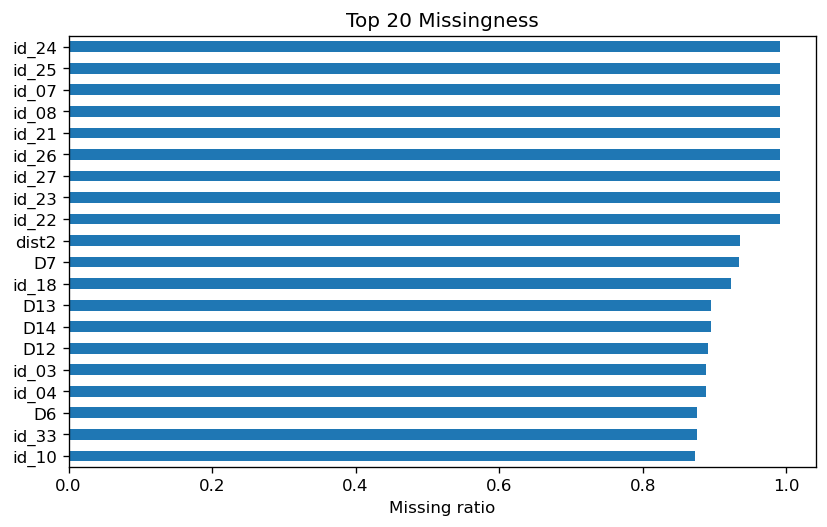

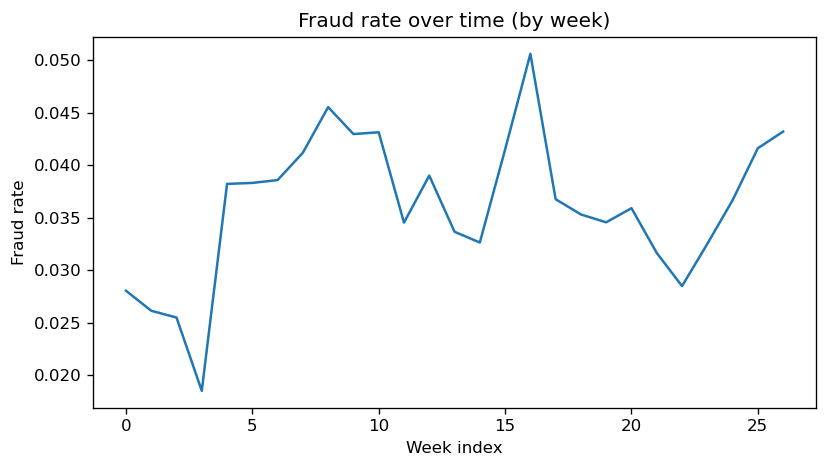

Fraud rates -> train=0.0352, val=0.0343, test=0.0348


In [6]:
trans = pd.read_csv(TRAIN_TRANSACTION_PATH)
iden  = pd.read_csv(TRAIN_IDENTITY_PATH)
df = trans.merge(iden, on="TransactionID", how="left")
assert {"isFraud","TransactionDT"}.issubset(df.columns)

card = data_card(df); card.to_csv(ART/"data_card.csv")
print(json.dumps({
    "rows": int(df.shape[0]),
    "cols": int(df.shape[1]),
    "join_key": "TransactionID",
    "target_prevalence": float(df["isFraud"].mean())
}, indent=2))

# Plots: top missingness + fraud rate over time
plot_missingness_top(df, topn=20, savepath=ART/"missingness_top20.png")
drift = fraud_rate_by_week(df); drift.to_csv(ART/"fraud_rate_by_week.csv", index=False)
plot_fraud_rate_week(drift, savepath=ART/"fraud_rate_week.png")

# Safe pre-split cleaning
df = clean_M_flags(df)
df = add_time_features(df)

# Time-ordered split
df = df.sort_values("TransactionDT").reset_index(drop=True)
n = len(df); i1 = int(0.70*n); i2 = int(0.85*n)
train_df = df.iloc[:i1].copy()
val_df   = df.iloc[i1:i2].copy()
test_df  = df.iloc[i2:].copy()

print("Fraud rates ->",
      f"train={train_df.isFraud.mean():.4f}, val={val_df.isFraud.mean():.4f}, test={test_df.isFraud.mean():.4f}")


# 4) Minimal preprocessing (keep numeric NaNs; per-column indicators; train-only freq encodings)

In [7]:
# Column-wise missing indicators in each split
for dset in (train_df, val_df, test_df):
    dset, _ = make_missing_indicators(dset, threshold=MISS_THRESH, exclude=["isFraud"])

# Prepare categoricals
cat_cols = [c for c in df.columns if df[c].dtype=='O']
for dset in (train_df, val_df, test_df):
    for c in cat_cols:
        dset[c] = unify_rare_levels(dset[c], RARE_CAT_MIN)

# Frequency-encode (fit on TRAIN, apply to VAL/TEST)
freq_maps = freq_encode_fit(train_df, cat_cols)
train_df = freq_encode_apply(train_df, freq_maps, cat_cols)
val_df   = freq_encode_apply(val_df,   freq_maps, cat_cols)
test_df  = freq_encode_apply(test_df,  freq_maps, cat_cols)

# Feature list (drop raw string cats & TransactionID)
drop_cols = set(["TransactionID"] + cat_cols + ["isFraud"])
feature_cols = [c for c in train_df.columns if c not in drop_cols and c != "TransactionDT"]

X_tr, y_tr = train_df[feature_cols], train_df["isFraud"].astype(int).to_numpy()
X_va, y_va = val_df[feature_cols],   val_df["isFraud"].astype(int).to_numpy()
X_te, y_te = test_df[feature_cols],  test_df["isFraud"].astype(int).to_numpy()

print(len(feature_cols), "features.")


686 features.


# 5.AAA) Real XGBoost Training

[0]	train-auc:0.82526	train-aucpr:0.18489	validation-auc:0.79432	validation-aucpr:0.17385
[200]	train-auc:0.94107	train-aucpr:0.66966	validation-auc:0.89831	validation-aucpr:0.51298
[400]	train-auc:0.96265	train-aucpr:0.74132	validation-auc:0.90642	validation-aucpr:0.54086
[600]	train-auc:0.97550	train-aucpr:0.79382	validation-auc:0.90981	validation-aucpr:0.55515
[800]	train-auc:0.98311	train-aucpr:0.83507	validation-auc:0.91049	validation-aucpr:0.56196
[1000]	train-auc:0.98822	train-aucpr:0.86958	validation-auc:0.91088	validation-aucpr:0.57047
[1200]	train-auc:0.99174	train-aucpr:0.89756	validation-auc:0.91002	validation-aucpr:0.57502
[1400]	train-auc:0.99415	train-aucpr:0.91980	validation-auc:0.90998	validation-aucpr:0.58029
[1600]	train-auc:0.99590	train-aucpr:0.93813	validation-auc:0.90867	validation-aucpr:0.58274
[1800]	train-auc:0.99709	train-aucpr:0.95190	validation-auc:0.90798	validation-aucpr:0.58407
[2000]	train-auc:0.99797	train-aucpr:0.96356	validation-auc:0.90741	validatio

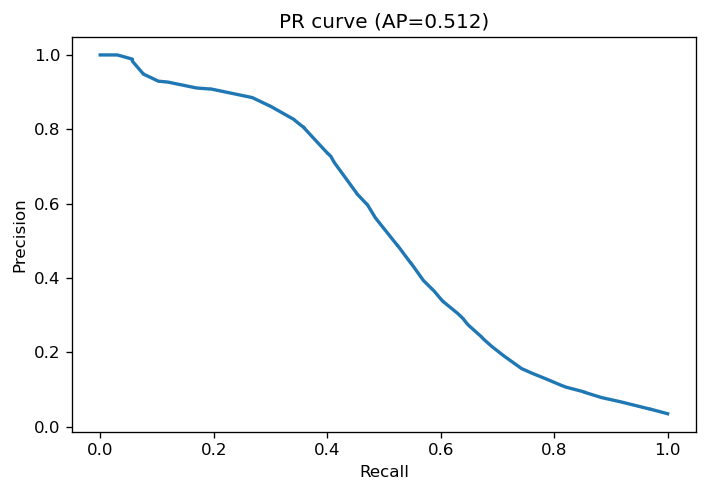

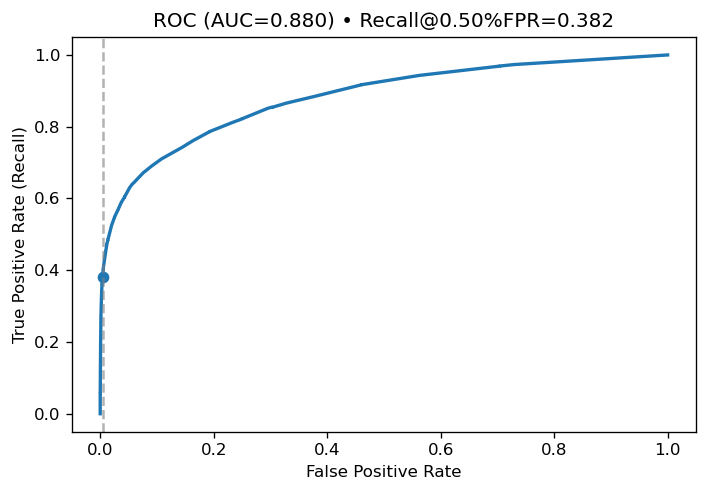

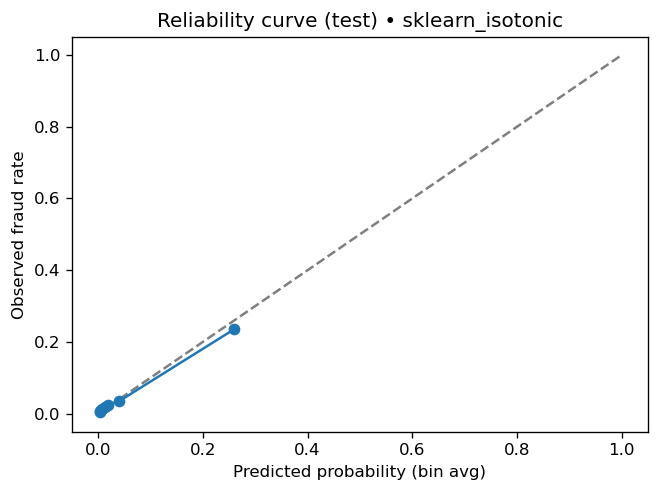

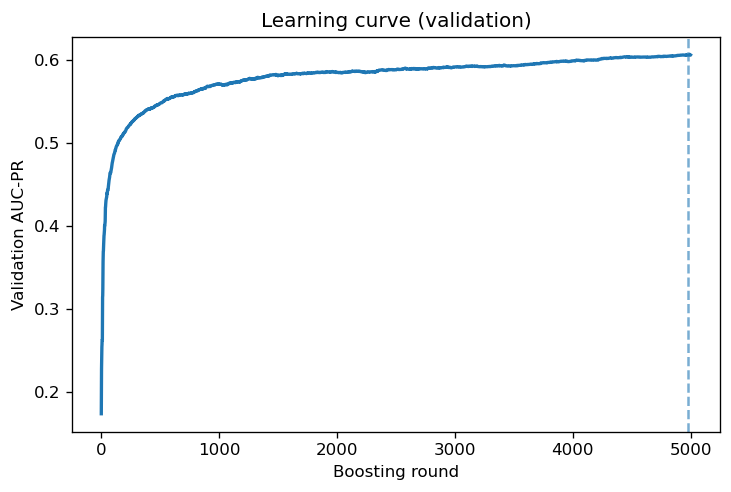

All Block 5 artifacts saved to ./artifacts


In [8]:
# ===== Unified Block 5 (robust): train + calibration + metrics + plots =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, xgboost as xgb
from pathlib import Path
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, roc_curve, brier_score_loss
)

ART = Path("./artifacts"); ART.mkdir(exist_ok=True)

# --- 1) Train with xgb.train (keeps eval history across versions) ---
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval   = xgb.DMatrix(X_va, label=y_va)

scale_pos_weight = float((len(y_tr) - y_tr.sum()) / max(1, y_tr.sum()))

params = {
    "objective": "binary:logistic",
    # log both metrics; Early Stopping uses the LAST metric & LAST eval set
    "eval_metric": ["auc", "aucpr"],   # ES on aucpr (last)
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "max_delta_step": 1,
    "scale_pos_weight": scale_pos_weight,
    "tree_method": "hist",   # harmless if ignored by older builds
}

evals_result = {}
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dval, "validation")],  # validation LAST → ES on validation-aucpr
    early_stopping_rounds=300,
    evals_result=evals_result,
    verbose_eval=200
)

# Best round/value (AUC-PR on validation)
vals_aupr = np.array(evals_result.get("validation", {}).get("aucpr", []), dtype=float)
best_round = int(vals_aupr.argmax()) if len(vals_aupr) else None
best_val = float(vals_aupr[best_round]) if best_round is not None else float("nan")
print(f"[Train] best validation AUC-PR={best_val:.5f} at round {best_round}")

# --- 2) Safe predictor that works on xgboost <2.0 and ≥2.0 ---
def booster_predict(booster, X, use_best=True):
    dm = xgb.DMatrix(X)
    if use_best:
        bi = getattr(booster, "best_iteration", None)
        if bi is not None:
            # Preferred on ≥2.0
            try:
                return booster.predict(dm, iteration_range=(0, bi + 1))
            except TypeError:
                pass
            # Fallback for <2.0
            ntree = getattr(booster, "best_ntree_limit", None)
            if ntree is None:
                ntree = bi + 1
            try:
                return booster.predict(dm, ntree_limit=ntree)
            except TypeError:
                pass
    # Final fallback: predict with all trees
    return booster.predict(dm)

# --- 3) Wrap booster as a sklearn classifier (for calibration/Quantus) ---
class XGBBoosterSK:
    def __init__(self, booster):
        self.booster = booster
        self.classes_ = np.array([0, 1])
        self._estimator_type = "classifier"  # tells sklearn it's a classifier
    def fit(self, X, y=None):               # no-op (cv='prefit' still validates)
        return self
    def predict_proba(self, X):
        p = booster_predict(self.booster, X, use_best=True)
        return np.column_stack([1.0 - p, p])
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)
    def get_booster(self):
        return self.booster

clf = XGBBoosterSK(booster)
model_for_shap = booster  # use this in your SHAP block: shap.TreeExplainer(model_for_shap)

# --- 4) Calibrate on VALIDATION (prefer sklearn; fallback to manual isotonic) ---
calibration_mode = "sklearn_isotonic"
try:
    cal = CalibratedClassifierCV(estimator=clf, method="isotonic", cv="prefit")
    cal.fit(X_va, y_va)
    def predict_proba_cal(X):
        return cal.predict_proba(X)
except Exception as e:
    print("[Calib] CalibratedClassifierCV failed, using manual isotonic. Reason:", repr(e))
    from sklearn.isotonic import IsotonicRegression
    calibration_mode = "manual_isotonic"
    p_va_raw = booster_predict(booster, X_va, use_best=True)
    iso = IsotonicRegression(out_of_bounds="clip", y_min=0.0, y_max=1.0)
    iso.fit(p_va_raw, y_va)
    def predict_proba_cal(X):
        p = booster_predict(booster, X, use_best=True)
        p_cal = iso.predict(p)
        return np.column_stack([1.0 - p_cal, p_cal])

# Calibrated probs on TEST
probs_te = predict_proba_cal(X_te)[:, 1]

# --- 5) Metrics (PR/ROC/Operating point/Calibration) ---
prauc = average_precision_score(y_te, probs_te)
rocauc = roc_auc_score(y_te, probs_te)
print(f"[TEST] PR-AUC={prauc:.4f} | ROC-AUC={rocauc:.4f}")

# Operating point: Recall@FPR=0.5%
fpr, tpr, thr = roc_curve(y_te, probs_te)
alpha = 0.005
idx = max(np.searchsorted(fpr, alpha, side="right")-1, 0)
recall_at_alpha = float(tpr[idx])
thr_at_alpha = float(thr[idx] if idx < len(thr) else thr[-1])

brier = float(brier_score_loss(y_te, probs_te))
print(f"Recall@FPR={alpha*100:.2f}% = {recall_at_alpha:.4f} (threshold≈{thr_at_alpha:.4f}) | Brier={brier:.5f}")

pd.DataFrame({
    "metric":["PR-AUC","ROC-AUC",f"Recall@FPR={alpha:.3f}","Brier","CalibrationMode"],
    "value":[prauc, rocauc, recall_at_alpha, brier, calibration_mode]
}).to_csv(ART/"model_eval_test_extended.csv", index=False)

# --- 6) Plots: PR, ROC, calibration (reliability), learning curve ---
# PR curve
p, r, _ = precision_recall_curve(y_te, probs_te)
plt.figure(figsize=(6,4.2)); plt.plot(r, p, lw=2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR curve (AP={prauc:.3f})")
plt.tight_layout(); plt.savefig(ART/"pr_curve.png", bbox_inches="tight"); plt.show()

# ROC + operating point marker
plt.figure(figsize=(6,4.2)); plt.plot(fpr, tpr, lw=2)
plt.axvline(alpha, ls="--", color="gray", alpha=0.6); plt.scatter([fpr[idx]],[tpr[idx]])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC (AUC={rocauc:.3f}) • Recall@{alpha*100:.2f}%FPR={recall_at_alpha:.3f}")
plt.tight_layout(); plt.savefig(ART/"roc_curve.png", bbox_inches="tight"); plt.show()

# Reliability (calibration) curve
prob_true, prob_pred = calibration_curve(y_te, probs_te, n_bins=10, strategy="quantile")
plt.figure(figsize=(5.6,4.2))
plt.plot([0,1],[0,1],'k--', alpha=0.5); plt.plot(prob_pred, prob_true, marker='o')
plt.xlabel("Predicted probability (bin avg)"); plt.ylabel("Observed fraud rate")
plt.title(f"Reliability curve (test) • {calibration_mode}")
plt.tight_layout(); plt.savefig(ART/"calibration_curve.png", bbox_inches="tight"); plt.show()

# Learning curve from eval history (AUC-PR over rounds)
if len(vals_aupr):
    plt.figure(figsize=(6.2,4.2))
    plt.plot(np.arange(len(vals_aupr)), vals_aupr, lw=2)
    if best_round is not None: plt.axvline(best_round, ls="--", alpha=0.6)
    plt.xlabel("Boosting round"); plt.ylabel("Validation AUC-PR")
    plt.title("Learning curve (validation)")
    plt.tight_layout(); plt.savefig(ART/"learning_curve_val_aucpr.png", bbox_inches="tight"); plt.show()

# --- 7) Save a tiny log for reproducibility ---
with open(ART/"block5_log.json","w") as f:
    json.dump({
        "scale_pos_weight": scale_pos_weight,
        "params": params,
        "best_round": int(best_round) if best_round is not None else None,
        "best_val_aucpr": best_val,
        "calibration_mode": calibration_mode,
        "test_metrics": {
            "pr_auc": prauc, "roc_auc": rocauc,
            "recall_at_fpr_0p5pct": recall_at_alpha, "brier": brier
        }
    }, f, indent=2)

print("All Block 5 artifacts saved to ./artifacts")


# 6) Select N=30 identical test rows (include positives)

In [9]:
# 6) Select N=30 identical test rows (include positives) — robust & reproducible
N = int(N_EXPLAIN)
min_pos = int(MIN_POS_EXPLAIN)
IDX_PATH = ART / "explain_sel_idx.npy"

#if IDX_PATH.exists():
#    sel_idx = np.load(IDX_PATH)
 #   print(f"Loaded {len(sel_idx)} explain indices from {IDX_PATH}")
#else:
pos_idx = np.where(y_te == 1)[0]
neg_idx = np.where(y_te == 0)[0]

# Target counts
take_pos = min(min_pos, len(pos_idx))
take_neg = min(N - take_pos, len(neg_idx))

# Initial sample without replacement (safe if enough rows exist)
sel_pos = rng.choice(pos_idx, size=take_pos, replace=False) if take_pos > 0 else np.array([], dtype=int)
sel_neg = rng.choice(neg_idx, size=take_neg, replace=False) if take_neg > 0 else np.array([], dtype=int)

sel_idx = np.r_[sel_pos, sel_neg]

# If still short, top up from the larger pool; allow replacement only as last resort
need = N - len(sel_idx)
if need > 0:
    pool = neg_idx if len(neg_idx) >= len(pos_idx) else pos_idx
    extra = rng.choice(pool, size=need, replace=(need > len(pool)))
    sel_idx = np.r_[sel_idx, extra]

# Finalize: sort by time (so explanations are chronologically ordered)
sel_idx = np.sort(sel_idx.astype(int))
np.save(IDX_PATH, sel_idx)
print(f"Saved {len(sel_idx)} explain indices to {IDX_PATH}")

# Build the explain set
X100 = X_te.iloc[sel_idx].to_numpy()
y100 = y_te[sel_idx]
feat_names = X_te.columns.tolist()
print("Explain set:", X100.shape, "| positives:", int(y100.sum()))



Saved 30 explain indices to artifacts/explain_sel_idx.npy
Explain set: (30, 686) | positives: 20


# 7) SHAP + LIME attributions (+ latency) and SHAP summary plot

SHAP latency per instance: 0.1738s


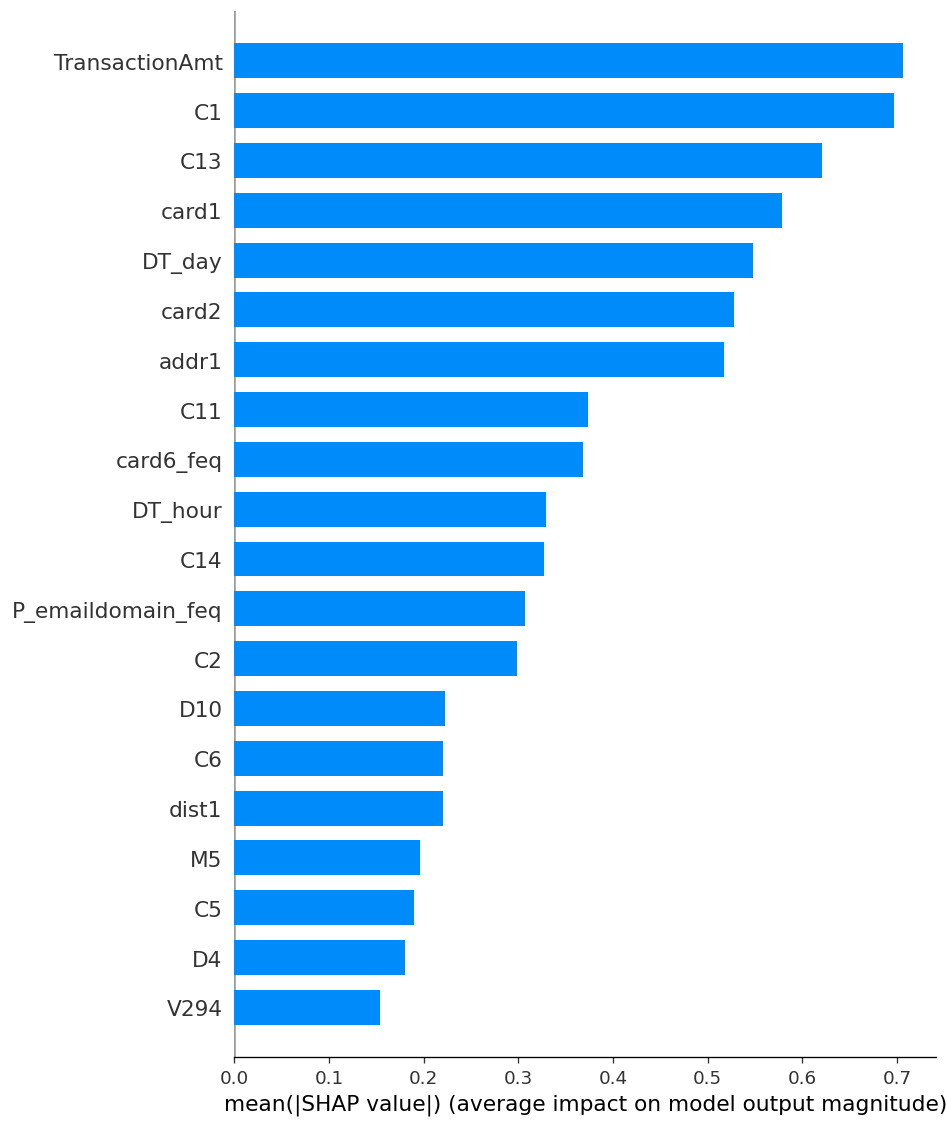

LIME latency per instance: 0.2044s


In [10]:
# 7) SHAP + LIME attributions (+ latency) and SHAP summary plot — robust to NaNs/zero-std
import time, json
import numpy as np
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer

# ---------- SHAP ----------
t0 = time.perf_counter()
try:
    explainer = shap.TreeExplainer(model_for_shap, model_output="probability")
    shap_out = explainer(X100)                       # new API → Explanation
    A_shap = np.asarray(shap_out.values, dtype="float64")
except Exception:
    explainer = shap.TreeExplainer(model_for_shap)   # fallback (margin/log-odds)
    shap_vals = explainer.shap_values(X100)          # legacy API
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]
    A_shap = np.asarray(shap_vals, dtype="float64")

lat_shap = (time.perf_counter() - t0) / max(1, len(X100))
print(f"SHAP latency per instance: {lat_shap:.4f}s")

plt.figure()
shap.summary_plot(A_shap, features=X100, feature_names=feat_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(ART/"shap_summary_bar.png", bbox_inches="tight")
plt.show()

# ---------- LIME (robust to NaNs/±inf & zero-std) ----------

def build_lime_ready_matrices(Xtr_df, Xb_np, seed=SEED):
    rng_local = np.random.default_rng(seed)
    Xtr = Xtr_df.to_numpy().astype("float64", copy=True)
    Xb  = Xb_np.astype("float64", copy=True)

    # Treat ±inf as NaN, then fill with TRAIN medians (all-NaN cols -> 0.0)
    Xtr[~np.isfinite(Xtr)] = np.nan
    Xb[~np.isfinite(Xb)]   = np.nan
    med = np.nanmedian(Xtr, axis=0)
    med = np.where(np.isfinite(med), med, 0.0)

    def fill_with_med(X):
        mask = ~np.isfinite(X)
        if mask.any():
            X[mask] = np.broadcast_to(med, X.shape)[mask]
        return X

    Xtr_L = fill_with_med(Xtr)
    X100_L = fill_with_med(Xb)

    # Ensure strictly positive std on TRAIN for LIME's sampler
    std = Xtr_L.std(axis=0)
    zero = (~np.isfinite(std)) | (std == 0)
    if zero.any():
        eps = 1e-12
        Xtr_L[:, zero] += eps * rng_local.standard_normal((Xtr_L.shape[0], int(zero.sum())))

    assert np.isfinite(Xtr_L).all()
    assert np.isfinite(X100_L).all()
    return Xtr_L, X100_L

Xtr_L, X100_L = build_lime_ready_matrices(X_tr, X100, seed=SEED)

# --- Safe calibrated predictor for LIME: adds column names if sklearn calibrator needs them ---
def predict_proba_cal_lime(X):
    XA = np.asarray(X)
    if XA.ndim == 1:
        XA = XA.reshape(1, -1)
    # Prefer sklearn calibrator if available
    if 'cal' in globals():
        try:
            return cal.predict_proba(XA)  # works if calibrator doesn't enforce names
        except Exception:
            import pandas as pd
            return cal.predict_proba(pd.DataFrame(XA, columns=feat_names))
    # Manual isotonic fallback (from Block 5)
    P = booster_predict(model_for_shap, XA, use_best=True)
    if 'iso' in globals():
        P = iso.predict(P)
    return np.column_stack([1.0 - P, P])

lime = LimeTabularExplainer(
    training_data=Xtr_L,
    feature_names=feat_names,
    class_names=["not_fraud", "fraud"],
    mode="classification",
    discretize_continuous=False,     # continuous sampling (safer)
    sample_around_instance=True,
    random_state=SEED,
)

def lime_dense_batch(Xb_for_lime, num_features=None, num_samples=2000):
    n, d = Xb_for_lime.shape
    if num_features is None:
        num_features = min(50, d)
    out = np.zeros((n, d), dtype="float64")
    for i, x_sanit in enumerate(Xb_for_lime):
        exp = lime.explain_instance(
            x_sanit, predict_proba_cal_lime, labels=[1],
            num_features=num_features, num_samples=num_samples
        )
        for j, w in exp.as_map()[1]:
            out[i, j] = w
    return out

t0 = time.perf_counter()
A_lime = lime_dense_batch(X100_L, num_samples=2000)
lat_lime = (time.perf_counter() - t0) / max(1, len(X100_L))
print(f"LIME latency per instance: {lat_lime:.4f}s")

# persist (optional)
np.save(ART/"A_shap.npy", A_shap)
np.save(ART/"A_lime.npy", A_lime)
with open(ART/"explain_latency.json","w") as f:
    json.dump({"lat_shap": float(lat_shap), "lat_lime": float(lat_lime)}, f, indent=2)


In [11]:
import numpy as np, torch, quantus
print("NumPy:", np.__version__)
print("Torch:", torch.__version__)
print("Quantus:", quantus.__version__)


NumPy: 1.26.4
Torch: 2.2.2
Quantus: 0.6.0


# 8) Quantus metrics (Fidelity + Robustness) + Conciseness + Latency; boxplots & diffs

,count,mean,std,min,25%,50%,75%,max
y_true,30.0,0.666667,4.794633e-01,0.000000,0.000000,1.000000,1.000000,1.000000
faith_shap,29.0,0.111438,1.825295e-01,-0.158130,-0.025184,0.129335,0.253682,0.439663
faith_lime,28.0,0.000943,1.071319e-01,-0.191129,-0.079046,0.003331,0.064643,0.224914
k_shap,30.0,51.533333,1.404852e+01,34.000000,40.750000,49.500000,58.750000,98.000000
k_lime,30.0,30.366667,1.902509e+00,26.000000,29.250000,30.500000,32.000000,34.000000
lat_shap,30.0,0.173825,5.646013e-17,0.173825,0.173825,0.173825,0.173825,0.173825
lat_lime,30.0,0.204412,0.000000e+00,0.204412,0.204412,0.204412,0.204412,0.204412


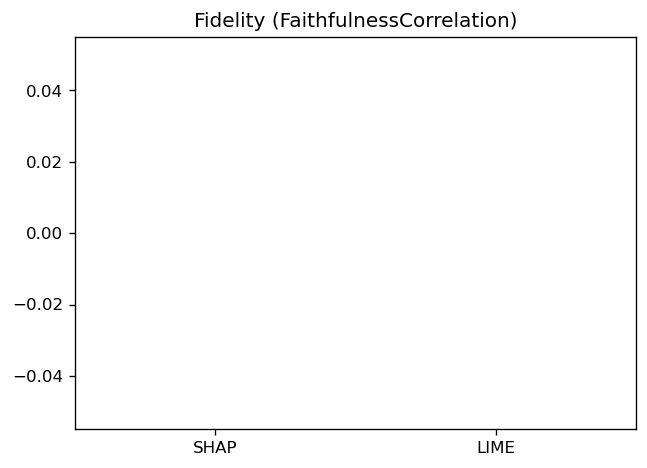

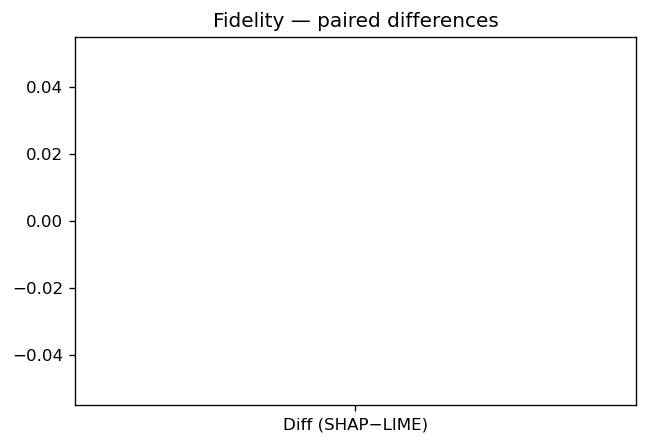

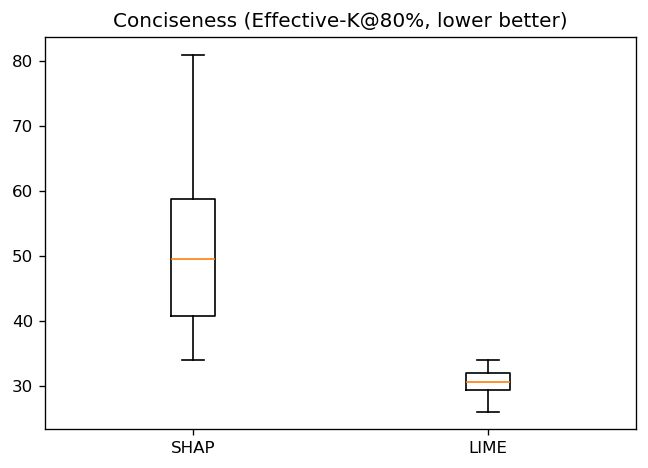

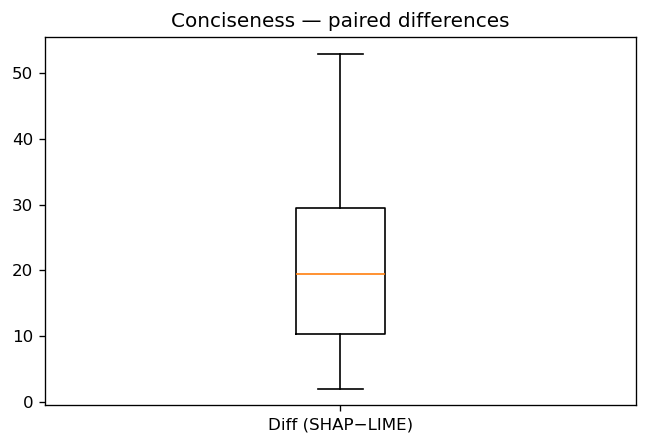

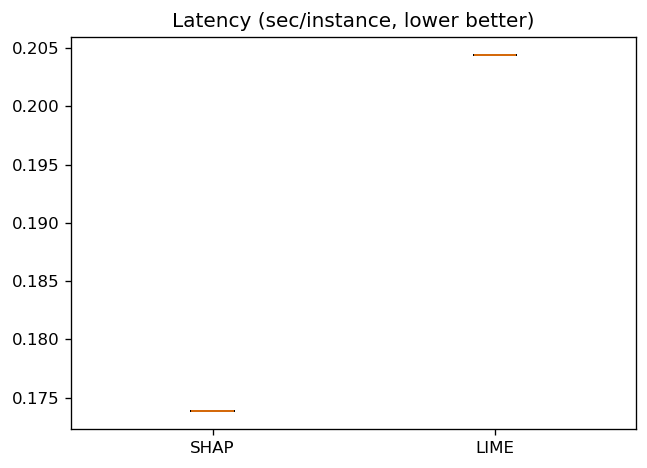

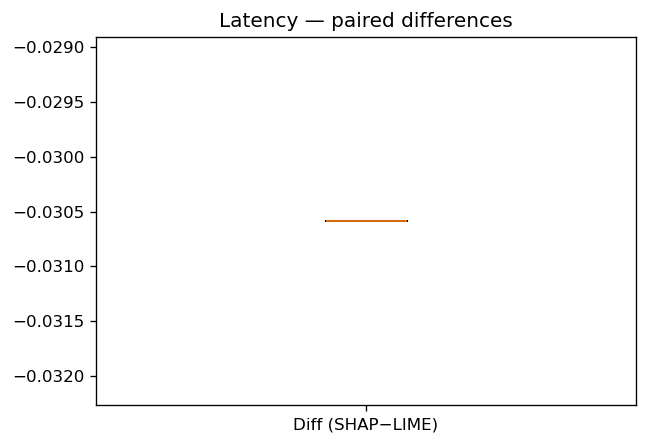

In [12]:
# ---- Block 8 (minimal & high-ROI): Faithfulness + Conciseness + Latency ----
import numpy as np, pandas as pd
import torch, importlib, quantus

# Make sure Quantus sees torch (avoids backend confusion)
importlib.reload(quantus)
quantus.__dict__['torch'] = torch

# ---- Inputs from earlier blocks expected in memory:
# X100, y100, A_shap, A_lime, predict_proba_cal_lime, ART, SEED, lat_shap, lat_lime

# ---- Coerce & sanitize ----
Xb     = np.asarray(X100,  dtype=float)     # (N, D)
yb     = np.asarray(y100,  dtype=int)       # (N,)
A_shap = np.asarray(A_shap, dtype=float)    # (N, D)
A_lime = np.asarray(A_lime, dtype=float)    # (N, D)

assert set(np.unique(yb)).issubset({0, 1}), "yb must be binary {0,1}"
N, D = Xb.shape

# Replace any weird values in attributions (Quantus hates NaN/inf)
for A in (A_shap, A_lime):
    np.nan_to_num(A, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

# ---- Tiny torch wrapper: returns (N,2) probs; works with Quantus torch backend ----
class QuantusTorchWrapper(torch.nn.Module):
    def forward(self, x: torch.Tensor):
        # Accept (N,1,D), (1,D), or (D,)
        if x.dim() == 3 and x.shape[1] == 1:
            x = x.squeeze(1)          # -> (N,D)
        elif x.dim() == 1:
            x = x.unsqueeze(0)        # -> (1,D)
        XA = x.detach().cpu().to(torch.float64).numpy()

        P = np.asarray(predict_proba_cal_lime(XA), dtype=np.float64)
        # Normalize to (N,) positive-class probability
        if P.ndim == 1:
            p_pos = np.clip(P, 0.0, 1.0)
        elif P.shape[1] == 2:
            p_pos = np.clip(P[:, 1], 0.0, 1.0)
        elif P.shape[1] == 1:
            p_pos = np.clip(P[:, 0], 0.0, 1.0)
        else:
            raise ValueError(f"Unexpected proba shape {P.shape}")

        p_neg = 1.0 - p_pos
        P_two = np.column_stack([p_neg, p_pos]).astype(np.float32, copy=False)  # (N,2)
        return torch.from_numpy(P_two).to(device=x.device)

qmodel  = QuantusTorchWrapper().eval()
qdevice = "cpu"

# ---- Channel-first for Quantus torch models ----
Xb_cf     = Xb[:, None, :]     # (N,1,D)
A_shap_cf = A_shap[:, None, :] # (N,1,D)
A_lime_cf = A_lime[:, None, :] # (N,1,D)

# ---- FaithfulnessCorrelation (fast & tabular-friendly) ----
subset_size_int = min(D, max(1, int(round(0.10 * D))))  # 10% of features as integer
m_faith = quantus.FaithfulnessCorrelation(
    subset_size=subset_size_int,
    perturb_baseline="mean",       # valid baseline keyword in Quantus 0.6
    return_aggregate=False,        # return per-instance scores
    display_progressbar=False,
)

# Run (channel_first=True)
faith_shap = m_faith(
    model=qmodel, x_batch=Xb_cf, y_batch=yb, a_batch=A_shap_cf,
    softmax=False, device=qdevice, channel_first=True
)
faith_lime = m_faith(
    model=qmodel, x_batch=Xb_cf, y_batch=yb, a_batch=A_lime_cf,
    softmax=False, device=qdevice, channel_first=True
)

# Normalize to flat float arrays and guarantee length N (pad/truncate as a safety net)
def _as_len_N(a, N):
    arr = np.asarray(a, dtype=float).ravel()
    if len(arr) < N:
        arr = np.pad(arr, (0, N - len(arr)), constant_values=np.nan)
    elif len(arr) > N:
        arr = arr[:N]
    return arr

faith_shap = _as_len_N(faith_shap, N)
faith_lime = _as_len_N(faith_lime, N)

# ---- Conciseness (Effective-K@80%) & Latency ----
def effective_k(A, mass=0.80):
    A_abs = np.abs(A)
    s = A_abs.sum(axis=1, keepdims=True)
    s[s == 0] = 1.0
    A_n = A_abs / s
    idx = np.argsort(-A_n, axis=1)
    A_sort = np.take_along_axis(A_n, idx, axis=1)
    csum = np.cumsum(A_sort, axis=1)
    return (csum < mass).sum(axis=1) + 1

k_shap = effective_k(A_shap, mass=0.80)
k_lime = effective_k(A_lime, mass=0.80)
lat_shap_vec = np.full(N, float(lat_shap))
lat_lime_vec = np.full(N, float(lat_lime))

# ---- Assemble & save per-instance table ----
metrics_df = pd.DataFrame({
    "y_true":      yb,
    "faith_shap":  faith_shap,
    "faith_lime":  faith_lime,
    "k_shap":      k_shap.astype(float),
    "k_lime":      k_lime.astype(float),
    "lat_shap":    lat_shap_vec,
    "lat_lime":    lat_lime_vec,
})
metrics_df.to_csv(ART/"xai_metrics_per_instance.csv", index=False)

# Quick summary (matches earlier blocks’ style)
display(metrics_df.describe(percentiles=[0.25, 0.5, 0.75]).T)

# ---- Paired visuals (reuse your helpers) ----
plot_metric_boxpairs(metrics_df["faith_shap"], metrics_df["faith_lime"],
                     "Fidelity (FaithfulnessCorrelation)", ART/"box_fidelity.png")
plot_paired_diffs(metrics_df["faith_shap"], metrics_df["faith_lime"],
                  "Fidelity", ART/"diff_fidelity.png")

plot_metric_boxpairs(metrics_df["k_shap"], metrics_df["k_lime"],
                     "Conciseness (Effective-K@80%, lower better)", ART/"box_conciseness.png")
plot_paired_diffs(metrics_df["k_shap"], metrics_df["k_lime"],
                  "Conciseness", ART/"diff_conciseness.png")

plot_metric_boxpairs(metrics_df["lat_shap"], metrics_df["lat_lime"],
                     "Latency (sec/instance, lower better)", ART/"box_latency.png")
plot_paired_diffs(metrics_df["lat_shap"], metrics_df["lat_lime"],
                  "Latency", ART/"diff_latency.png")



# 9) Paired Wilcoxon + HL (median diff) + 95% CI + Holm correction → results table

In [13]:
# ---- Block 9: Paired tests + HL median diff with bootstrap CIs (NaN-safe) ----
import numpy as np, pandas as pd
from scipy.stats import wilcoxon

# HL estimator (median of paired differences) + bootstrap CI on the median
def hl_ci_bootstrap(diff, B=4000, seed=SEED):
    rng = np.random.default_rng(seed)
    diff = np.asarray(diff, dtype=float)
    diff = diff[np.isfinite(diff)]
    if diff.size == 0:
        return np.nan, np.nan, np.nan
    hl = float(np.median(diff))
    meds = []
    n = diff.size
    for _ in range(B):
        samp = diff[rng.integers(0, n, size=n)]
        meds.append(np.median(samp))
    lo, hi = np.percentile(meds, [2.5, 97.5])
    return hl, float(lo), float(hi)

# Build the metric pairs dynamically based on what exists in metrics_df
pairs = {
    "Fidelity (FaithfulnessCorrelation)": ("faith_shap", "faith_lime", "greater"),  # higher is better
    "Conciseness (Effective-K@80%)":      ("k_shap",     "k_lime",     "greater"),  # we negate later (lower better)
    "Latency (sec/instance)":             ("lat_shap",   "lat_lime",   "greater"),  # negate later (lower better)
}

# If robustness columns exist (e.g., you later add MaxSensitivity), include them automatically:
if {"sens_shap", "sens_lime"}.issubset(metrics_df.columns):
    pairs = {"Robustness (MaxSensitivity)": ("sens_shap", "sens_lime", "greater"), **pairs}

rows, raw_p = [], []

for name, (col_s, col_l, alt) in pairs.items():
    s = metrics_df[col_s].to_numpy(dtype=float)
    l = metrics_df[col_l].to_numpy(dtype=float)

    # For metrics where lower is better, flip sign so "greater" means SHAP better than LIME
    if name.startswith("Conciseness") or name.startswith("Latency") or name.startswith("Robustness"):
        s = -s
        l = -l

    # NaN-safe mask (faith_* may have NaNs due to padding)
    mask = np.isfinite(s) & np.isfinite(l)
    s, l = s[mask], l[mask]

    if s.size == 0:
        stat, p = np.nan, 1.0
        hl, lo, hi = np.nan, np.nan, np.nan
    else:
        diff = s - l
        # If all diffs are zero, wilcoxon will error → handle gracefully
        if np.all(diff == 0):
            stat, p = 0.0, 1.0
            hl, lo, hi = 0.0, 0.0, 0.0
        else:
            stat, p = wilcoxon(diff, zero_method="wilcox", alternative=alt, mode="auto")
            hl, lo, hi = hl_ci_bootstrap(diff)

    rows.append([name, hl, lo, hi, stat, p])
    raw_p.append(p)

# Holm–Bonferroni across whatever tests actually ran
p_adj, sig = holm_bonferroni(raw_p, alpha=0.05) if len(raw_p) else ([], [])
for i in range(len(rows)):
    rows[i] += [p_adj[i], "YES" if (i < len(sig) and sig[i]) else "NO"]

summary = pd.DataFrame(rows, columns=[
    "Metric", "HL_median_diff(SHAP-LIME)", "CI95_lo", "CI95_hi",
    "Wilcoxon_stat", "p", "p_adj_Holm", "Significant?"
])
display(summary)
summary.to_csv(ART/"wilcoxon_summary.csv", index=False)


,Metric,HL_median_diff(SHAP-LIME),CI95_lo,CI95_hi,Wilcoxon_stat,p,p_adj_Holm,Significant?
0,Fidelity (FaithfulnessCorrelation),0.125982,0.006119,0.244787,310.0,6.811850e-03,1.362370e-02,YES
1,Conciseness (Effective-K@80%),-19.500000,-24.000000,-12.500000,0.0,9.999991e-01,9.999991e-01,NO
2,Latency (sec/instance),0.030587,0.030587,0.030587,465.0,2.160232e-08,6.480695e-08,YES


# 10) Lightweight compliance log (reproducibility)

In [14]:
# ---- Block 10: run metadata log (aligned with Blocks 5–9) ----
import json
from pathlib import Path

log = {
  "seed": int(SEED),
  "split": {
    "train": 0.70, "val": 0.15, "test": 0.15,
    "sorted_by": "TransactionDT"
  },
  "preprocess": {
    "keep_numeric_NaN": True,
    "missing_indicator_threshold": float(MISS_THRESH),
    "categorical_encoding": "frequency-encoding (fit on TRAIN only; unseen→0)",
    "rare_cat_min": int(RARE_CAT_MIN),
    "time_features": ["DT_day", "DT_week", "DT_hour"]
  },
  "model": {
    "type": "xgboost.train (tree_method='hist')",
    "params": params,                              # from Block 5
    "scale_pos_weight": float((len(y_tr)-y_tr.sum())/max(1, y_tr.sum())),
    "eval_metric_logged": ["auc","aucpr"],
    "early_stopping_rounds": 300,
    "early_stopping_target": "validation aucpr (last metric, last eval set)",
    "best_round": int(best_round) if best_round is not None else None,
    "best_val_aucpr": float(best_val),
    "calibration": calibration_mode               # "sklearn_isotonic" or "manual_isotonic"
  },
  "test_metrics": {
    "pr_auc": float(prauc),
    "roc_auc": float(rocauc),
    "recall_at_fpr_0p5pct": float(recall_at_alpha),
    "brier": float(brier)
  },
  "xai": {
    "N_instances": int(N_EXPLAIN),
    "min_positives_target": int(MIN_POS_EXPLAIN),
    "selection_file": str(ART/"explain_sel_idx.npy"),
    "SHAP": "TreeExplainer (probability_mode, bar-summary saved)",
    "LIME": {
      "discretize_continuous": False,
      "sample_around_instance": True,
      "num_features": "min(50, d)",
      "num_samples": 2000
    },
    "quantus_metrics": [
      "FaithfulnessCorrelation (subset≈10% of D, baseline='mean', per-instance)"
    ],
    "custom_metrics": [
      "Effective-K@80% (conciseness)",
      "Latency (sec/instance)"
    ]
  },
  "files_out": {
    "data_card": str(ART/"data_card.csv"),
    "fraud_drift": str(ART/"fraud_rate_by_week.csv"),
    "plots": [
      str(ART/"missingness_top20.png"),
      str(ART/"fraud_rate_week.png"),
      str(ART/"pr_curve.png"),
      str(ART/"roc_curve.png"),
      str(ART/"calibration_curve.png"),
      str(ART/"learning_curve_val_aucpr.png"),
      str(ART/"shap_summary_bar.png"),
      str(ART/"box_fidelity.png"),
      str(ART/"diff_fidelity.png"),
      str(ART/"box_conciseness.png"),
      str(ART/"diff_conciseness.png"),
      str(ART/"box_latency.png"),
      str(ART/"diff_latency.png")
    ],
    "xai_metrics_per_instance": str(ART/"xai_metrics_per_instance.csv"),
    "wilcoxon_summary": str(ART/"wilcoxon_summary.csv")
  },
  "env": {
    "numpy": np.__version__,
    "torch": torch.__version__,
    "quantus": quantus.__version__
  }
}

with open(ART/"run_log.json","w") as f:
  json.dump(log, f, indent=2)
print("Logged →", ART/"run_log.json")



Logged → artifacts/run_log.json
